This file examines different models, and at the end, pickles a model, which can be used for predicting critical temp, Tc.
There will be another file for predictions based on the pickeled model.

# Descriptive statistics

In [2]:
!pip install xgboost

    100% |████████████████████████████████| 16.6MB 3.2MB/s eta 0:00:01   28% |█████████▎                      | 4.8MB 41.9MB/s eta 0:00:01
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
# import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics.scorer import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
import time
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn import svm
from sklearn import ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import pickle
from sklearn.neural_network import MLPRegressor

In [25]:
#These two definitions come handy in several places below
scorer = make_scorer(mse, greater_is_better=False)# defining the scorer for cross validation
def rmse(mseLst):# root mean squared error obtained from a list of squared mean error
    avg_mse=statistics.mean(mseLst)
    return math.sqrt(avg_mse)
def pltxy(y_test,y_pred):# plot y_pred vs y_test and a linear regression
    from numpy.polynomial.polynomial import polyfit
    b, m = polyfit(y_test,y_pred, 1)
    plt.ylabel('predicted Tc')
    plt.xlabel('measured Tc')
    plt.xlim(right=150)
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, b + m * y_test, '-', color='red')

In [26]:
# get the csv files as DataFrames
data=pd.read_csv('train.csv')# file containing feaures and Tc
material=pd.read_csv('unique_m.csv')# file containint composition and Tc
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33, random_state=0)
Columns=X_train.columns# this is used in running the prediction function.
# pick Columns
outfile=open('Columns', 'wb')
pickle.dump(Columns, outfile)
outfile.close()

n=3# number of cross validations. If N>1, then some of the test data is used for training, which is a downside, 
# but in return we get an average.

In [27]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [28]:
material.head()

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


Get a plot that shows the most common elements

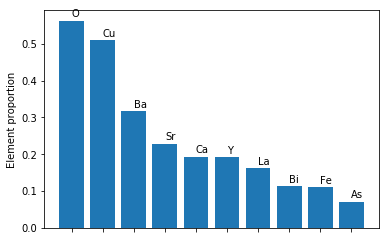

In [29]:
elements=material.iloc[:,:-2]# remove the last two columns (Tc and composition)
sortedElements=(elements!=0).sum().sort_values(ascending=False)/material.shape[0]
portionList=pd.Series.tolist(sortedElements)
elementList=pd.Series.tolist(sortedElements.index)
plt.ylabel('Element proportion')
for i in range(10):
    plt.annotate(elementList[i], (elementList[i],portionList[i]+.01) )
plt.xticks(visible=False)
plt.bar(elementList[:10],portionList[:10])
plt.savefig('Frequency_Plot.png')
plt.show()

Histogram of Tc

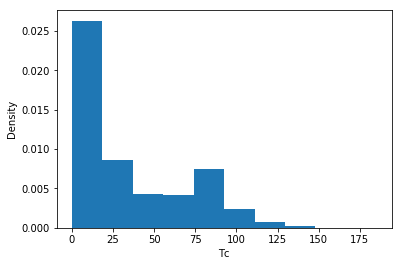

In [30]:
# histogram of Tc
Tc=pd.Series.tolist(material.critical_temp)
plt.xlabel('Tc')
plt.ylabel('Density')
plt.hist(Tc, density=True)
plt.savefig('Histogram_Tc.png')
plt.show()

# Predictive models of Tc

In all models, the test sampels are 1/3 and training is 2/3 of total samples.
- Mean
- Linear regression
- Regression tree
- Ridge (linear regression with regularization)
- Support Vector Machine
- Ensemble methods:
    - Gradient boost regression. 
    - Adaboost
    - Random Forrest
    - xgBoost

## Mean
Mean is the simplest way of predicting Tc. 
Our metric for evaluating the fitness of a model is to measure its root mean square error (rmse).
predicting all outcomes as means, results to rmse of 34.22 Kelvins

In [10]:
mseList=[]# this is a list of rmse for n number of tests
for i in range(n):
    if n>1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    y_pred = [y_train.mean()]*len(y_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)# out of sample rsme
print(oos_rmse)

34.11350858939987


## Linear regression
We don't have any hyperparameters. We do cross validation to get average performance.
As shown below, With linear regression, the out of sample rmse is 17.6

oos_rmse: 17.79


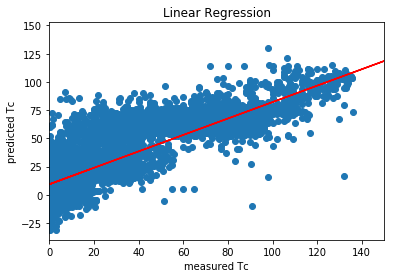

In [31]:
n=5# number of cross validations
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n>1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('oos_rmse: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('Linear Regression')
plt.savefig('Linear_Regression.png')
plt.show()
fileName='LinearRegre'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

## Regression tree

Two parts: First part is to do cross validation using GridSearchCV to optimze Max_depth.
The second part is to choose the best depth, and train and test the model. We cross validate here as well to get an average.

In [32]:
startTime=time.time()
parameters={'max_depth':[3,6,9,12,15,18,21,24,27,30]}
model= GridSearchCV(DecisionTreeRegressor(), param_grid=parameters, scoring=scorer, cv=10)
model.fit(X_train,y_train)
# pickle the grid search
fileName='RegressionTree-Gridsearch'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
Rtree_time=time.time()-startTime

In [33]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)

best estimator = DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


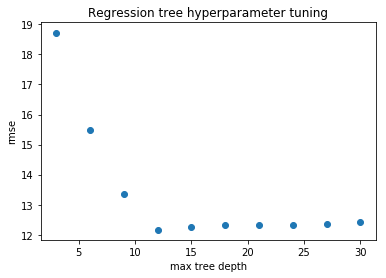

In [36]:
rmseLst=[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']]
plt.scatter(parameters['max_depth'],rmseLst)
plt.title('Regression tree hyperparameter tuning')
plt.xlabel('max tree depth')
plt.ylabel('rmse')
plt.savefig('RegressionTreeHyperparameterTuning.png')
plt.show()

max_depth=12 makes the most sense

oos_rmse: 12.75


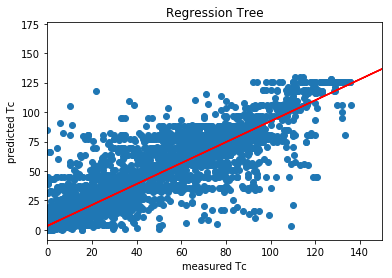

In [38]:
Depth=12 #maximum tree depth
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n>1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = DecisionTreeRegressor(max_depth=Depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('oos_rmse: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('Regression Tree')
plt.savefig('Regression_Tree.png')
plt.show()

# pickle the grid search
fileName='RegressionTree-Gridsearch'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

#  Regression with regularization
Let's see if we gain anything by regularizing the linear regression model.
Regularization is when we suspect some of the features are noise, and we'd like to mitigate their impact.
Two options for regularization are Lasso and Ridge

Two steps:
1st:Using cross validation, find the optimal value of alpha. 
2nd:Choose the best alpha and train the model and predict outcome

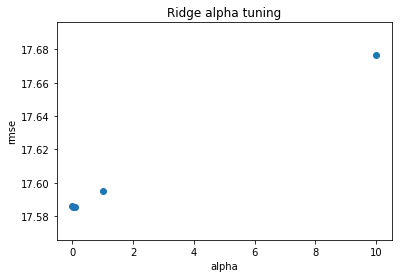

In [39]:
#step #1
parameters={'alpha':[0.001,.01,.1,1,10]}
model= GridSearchCV(Ridge(), param_grid=parameters, scoring=scorer, cv=5)
model.fit(X_train,y_train)
plt.scatter(parameters['alpha'],[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']])
plt.title('Ridge alpha tuning')
plt.xlabel('alpha')
plt.ylabel('rmse')
plt.savefig('Ridge_Alpha_tuning.png')
plt.show()

# pickle the grid search
fileName='Ridge_Gridsearch'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

In [40]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)

best estimator = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


As shown above, tuning does not help. The linear regression without any tuning resulted to rmse of 17.6. But for completeness, we can run the Ridge model with alpha=0.1

oos_rmse: 17.55


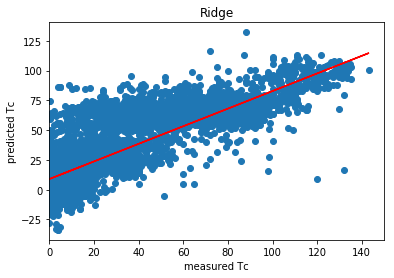

In [41]:
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n>1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = Ridge(alpha=.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('oos_rmse: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('Ridge')
plt.savefig('Ridge.png')
plt.show()

# pickle the grid search
fileName='Ridge'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

# Support vector machine
SVM was very slow and the results were not good. We did not pursue it further

In [ ]:
startTime=time.time()
parameters={'kernel':['linear', 'rbf'], 'C':[1,.5], 'epsilon':[0.1, 0.2] }
model= GridSearchCV(svm.SVR(), param_grid=parameters, scoring=scorer, cv=4, verbose=5)
model.fit(X_train,y_train)
# pickle the grid search
fileName='SVM_GridSearchCV'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
SVM_time=time.time()-startTime

Fitting 4 folds for each of 8 candidates, totalling 32 fits
[CV] C=1, epsilon=0.1, kernel=linear .................................


From above tuning, we choose kernel C and epsilon. See the plots below


In [ ]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)


In [ ]:
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n>1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = svm.SVR(C=, epsilon=, kernel=)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('oos_rmse: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('SVM')
plt.show()
plt.savefig('SVM.png')
# pickle the grid search
fileName='SVM'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

# Gradient boost regression

In [70]:
# tune hyperparameters
startTime=time.time()
parameters = {'max_depth': [4, 8, 12, 15, 18, 22], 'min_samples_split': [4, 8,12,16,20], 'loss': ['ls']}
model= GridSearchCV(ensemble.GradientBoostingRegressor(), param_grid=parameters, scoring=scorer, cv=3, verbose=5)
model.fit(X_train, y_train)
# pickle the grid search
fileName='GB_GridSearchCV'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
GB_time=time.time()-startTime

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] loss=ls, max_depth=4, min_samples_split=4 .......................
[CV]  loss=ls, max_depth=4, min_samples_split=4, score=-130.89189854165676, total=   7.3s
[CV] loss=ls, max_depth=4, min_samples_split=4 .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV]  loss=ls, max_depth=4, min_samples_split=4, score=-139.06230131881892, total=   6.6s
[CV] loss=ls, max_depth=4, min_samples_split=4 .......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV]  loss=ls, max_depth=4, min_samples_split=4, score=-148.27396615625494, total=   6.2s
[CV] loss=ls, max_depth=4, min_samples_split=8 .......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.3s remaining:    0.0s


[CV]  loss=ls, max_depth=4, min_samples_split=8, score=-131.34404942631338, total=   6.6s
[CV] loss=ls, max_depth=4, min_samples_split=8 .......................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.0s remaining:    0.0s


[CV]  loss=ls, max_depth=4, min_samples_split=8, score=-138.48778513068254, total=   7.3s
[CV] loss=ls, max_depth=4, min_samples_split=8 .......................
[CV]  loss=ls, max_depth=4, min_samples_split=8, score=-146.45234743172355, total=   8.3s
[CV] loss=ls, max_depth=4, min_samples_split=12 ......................
[CV]  loss=ls, max_depth=4, min_samples_split=12, score=-131.81337989513648, total=  14.6s
[CV] loss=ls, max_depth=4, min_samples_split=12 ......................
[CV]  loss=ls, max_depth=4, min_samples_split=12, score=-137.35661858374823, total=  10.6s
[CV] loss=ls, max_depth=4, min_samples_split=12 ......................
[CV]  loss=ls, max_depth=4, min_samples_split=12, score=-146.89046232054594, total=   7.1s
[CV] loss=ls, max_depth=4, min_samples_split=16 ......................
[CV]  loss=ls, max_depth=4, min_samples_split=16, score=-131.0344260552624, total=   6.5s
[CV] loss=ls, max_depth=4, min_samples_split=16 ......................
[CV]  loss=ls, max_depth=4, min

[CV]  loss=ls, max_depth=15, min_samples_split=16, score=-114.54051819459181, total=  49.1s
[CV] loss=ls, max_depth=15, min_samples_split=16 .....................
[CV]  loss=ls, max_depth=15, min_samples_split=16, score=-125.89429005432594, total=  49.7s
[CV] loss=ls, max_depth=15, min_samples_split=20 .....................
[CV]  loss=ls, max_depth=15, min_samples_split=20, score=-105.74748828683117, total=  44.6s
[CV] loss=ls, max_depth=15, min_samples_split=20 .....................
[CV]  loss=ls, max_depth=15, min_samples_split=20, score=-111.80143032671333, total=  44.3s
[CV] loss=ls, max_depth=15, min_samples_split=20 .....................
[CV]  loss=ls, max_depth=15, min_samples_split=20, score=-121.19779504670859, total=  45.6s
[CV] loss=ls, max_depth=18, min_samples_split=4 ......................
[CV]  loss=ls, max_depth=18, min_samples_split=4, score=-131.4810964858487, total= 2.9min
[CV] loss=ls, max_depth=18, min_samples_split=4 ......................
[CV]  loss=ls, max_depth

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 93.0min finished


In [71]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)
model.cv_results_

best estimator = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=8, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


C:\Users\10134838\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\10134838\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\10134838\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*

{'mean_fit_time': array([  6.75806729,   7.47078482,  10.86327728,   6.53590377,
          8.88649273,  22.22029336,  21.41949487,  23.223768  ,
         19.8128895 ,  18.68967136,  55.65533686,  43.10688027,
         37.80108007,  34.26442599,  31.86882925, 106.97515066,
         69.64423513,  56.51659393,  49.77368911,  44.85725347,
        200.78504602, 116.30857078,  84.32724714,  70.32138244,
         63.57985481, 261.74138459, 135.30908998,  98.56576602,
         79.39525493,  68.27390202]),
 'std_fit_time': array([ 0.45171585,  0.72339057,  3.06313922,  0.19407729,  2.35870075,
         1.61848303,  0.67333018,  4.82374281,  0.92322974,  2.06112411,
         2.81783749,  0.39435023,  0.37128253,  0.37303572,  0.31100899,
         2.40625345,  1.40478356,  1.03487382,  0.489252  ,  0.55866965,
        19.37009496,  4.49778601,  3.41365793,  1.4298648 ,  2.33408496,
         4.70772136,  3.57913314,  3.17603944,  1.65100149,  1.06903991]),
 'mean_score_time': array([0.01562413, 0.

In [61]:
#Instead of running the abovecode, unpickle
fileName='GB_GridSearchCV'
infile=open(fileName,'rb')
model=pickle.load(infile)
infile.close()
parameters = {'max_depth': [4, 8, 12, 15, 18, 22], 'min_samples_split': [4, 8,12,16,20], 'loss': ['ls']}



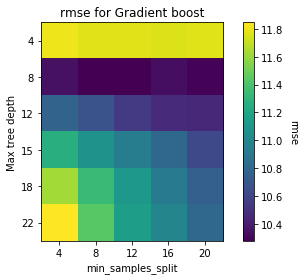

In [72]:
# heatmap of the score for different hyperparameters
# X axis: depth
# y axis: min_sample_split

rmseLst=[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']]
SCORE= np.array(rmseLst)    # ndarray of all the scores
SCORE.shape=(len(parameters['max_depth']),len(parameters['min_samples_split']))
fig, ax = plt.subplots()
im = ax.imshow(SCORE)
ax.set_xticks(np.arange(len(parameters['min_samples_split'])))
ax.set_yticks(np.arange(len(parameters['max_depth'])))
ax.set_xticklabels(parameters['min_samples_split'])
ax.set_yticklabels(parameters['max_depth'])
ax.set_title("rmse for Gradient boost")
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Max tree depth')
# Create colorbar
cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel(rotation=-90, va="bottom", ylabel= 'rmse')

fig.tight_layout()
plt.savefig('GB-Heatmap.png')
plt.show()

oos_rmse: 9.67


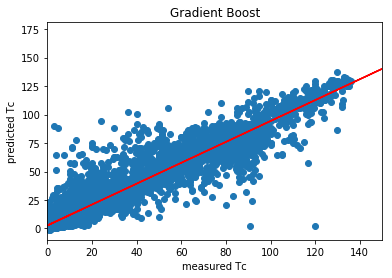

In [51]:
# now that we choose the hyperparameter values and run the model.
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n > 1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = ensemble.GradientBoostingRegressor(max_depth = 10, min_samples_split=16)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('oos_rmse: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('Gradient Boost')
plt.savefig('GB.png')
plt.show()

fileName='GB_model'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

oos_rmse: 6.80


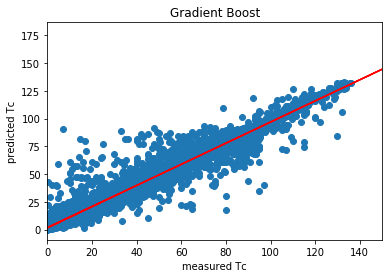

In [48]:
# instead of running the above code, unpickle
fileName='GB_model'
infile=open(fileName,'rb')
model=pickle.load(infile)
infile.close()
y_pred = model.predict(X_test)
mseList=mse(y_test,y_pred)
oos_rmse=math.sqrt(abs(mseList))
print('oos_rmse: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('Gradient Boost')
plt.savefig('GB.png')
plt.show()


Let's look at the importance of each feature to get an idea about the importance of each feature on Tc

In [53]:
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
imp=pd.DataFrame({"feature":X_train.columns, 'Importance':feature_importance})
imp.sort_values('Importance')

,feature,Importance
0,number_of_elements,0.029177
77,range_Valence,0.173262
37,range_Density,0.263879
71,mean_Valence,0.445561
73,gmean_Valence,0.500145
57,range_FusionHeat,0.801898
47,range_ElectronAffinity,1.101306
75,entropy_Valence,1.158090
17,range_fie,1.569040
19,std_fie,1.669452


# Adaboost method to boosting

In [16]:
# hyperparameter tuning
startTime=time.time()
parameters = {'learning_rate': [.05,0.1,1]}
model= GridSearchCV(ensemble.AdaBoostRegressor(), param_grid=parameters, scoring=scorer, cv=4, verbose=5)
model.fit(X_train, y_train)
# pickle the grid search
fileName='Adaboost_GridSearchCV'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
Ada_time=time.time()-startTime

Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV] learning_rate=0.05 ..............................................
[CV] ..... learning_rate=0.05, score=-319.2007955508456, total=   9.4s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ..... learning_rate=0.05, score=-318.2526834877204, total=  10.0s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.7s remaining:    0.0s


[CV] ..... learning_rate=0.05, score=-319.8431071921857, total=  10.0s
[CV] learning_rate=0.05 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.0s remaining:    0.0s


[CV] ..... learning_rate=0.05, score=-336.5605948487583, total=   9.5s
[CV] learning_rate=0.1 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.7s remaining:    0.0s


[CV] ..... learning_rate=0.1, score=-304.81304021554763, total=   9.0s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.1, score=-301.98718676828855, total=   8.8s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.1, score=-300.05683868999154, total=   8.8s
[CV] learning_rate=0.1 ...............................................
[CV] ..... learning_rate=0.1, score=-308.22400901896333, total=   8.8s
[CV] learning_rate=1 .................................................
[CV] ....... learning_rate=1, score=-349.39136025233694, total=   6.4s
[CV] learning_rate=1 .................................................
[CV] ........ learning_rate=1, score=-375.4159788316005, total=   5.9s
[CV] learning_rate=1 .................................................
[CV] ....... learning_rate=1, score=-313.42184673741366, total=   3.4s
[CV] learning_rate=1 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.6min finished


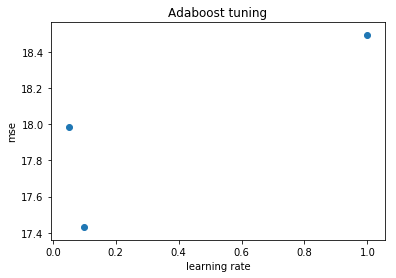

<Figure size 432x288 with 0 Axes>

In [17]:
rmseLst=[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']]
plt.scatter(parameters['learning_rate'], rmseLst)
plt.title('Adaboost tuning')
plt.xlabel('learning rate')
plt.ylabel('mse')
plt.savefig('AdaBoost_tuning.png')
plt.show()

In [18]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)


best estimator = AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=50, random_state=None)


oos_rmse of Adaboost: 17.47


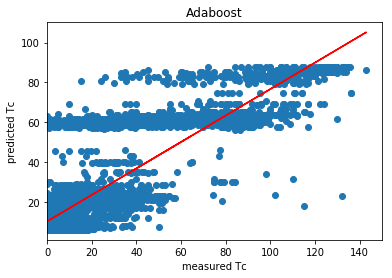

<Figure size 432x288 with 0 Axes>

In [20]:
# run model with the chosen hyperparamter (learning rate)
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n >1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = AdaBoostRegressor(learning_rate=.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('oos_rmse of Adaboost: %0.2f'%oos_rmse)
pltxy(y_test,y_pred)
plt.title('Adaboost')
plt.savefig('Adaboost.png')
plt.show()
fileName='AdaBoost_model'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

# Random Forrest
The code below was run on AWS, and the gridsearch was pickled.

In [8]:
# hyperparameter tuning
startTime=time.time()
parameters = {'n_estimators': [10,50, 100], 'max_depth':[5, 10, 15, 20, 30, 35]}
model= GridSearchCV(RandomForestRegressor(), param_grid=parameters, scoring=scorer, cv=3, verbose=5)
model.fit(X_train, y_train)
# pickle the model
fileName='RandomForrest_GridSearchCV'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
# to unpickle, do the following:
# fileName='RandomForrest_model'
# infile=open(fileName,'rb')
# model=pickle.load(infile)
#infile.close()
RF_time=time.time()-startTime
rmseLst=[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']]


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] max_depth=5, n_estimators=10 ....................................
[CV]  max_depth=5, n_estimators=10, score=-249.48172427025904, total=   2.0s
[CV] max_depth=5, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  max_depth=5, n_estimators=10, score=-215.61982908611313, total=   1.9s
[CV] max_depth=5, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV]  max_depth=5, n_estimators=10, score=-247.19423417890414, total=   1.9s
[CV] max_depth=5, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.1s remaining:    0.0s


[CV]  max_depth=5, n_estimators=10, score=-247.84814493464097, total=   2.0s
[CV] max_depth=5, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.2s remaining:    0.0s


[CV]  max_depth=5, n_estimators=50, score=-243.69116052521426, total=  11.3s
[CV] max_depth=5, n_estimators=50 ....................................
[CV]  max_depth=5, n_estimators=50, score=-214.25756977658284, total=  10.6s
[CV] max_depth=5, n_estimators=50 ....................................
[CV]  max_depth=5, n_estimators=50, score=-244.59687465615698, total=  10.3s
[CV] max_depth=5, n_estimators=50 ....................................
[CV]  max_depth=5, n_estimators=50, score=-239.8194723023208, total=  11.5s
[CV] max_depth=5, n_estimators=100 ...................................
[CV]  max_depth=5, n_estimators=100, score=-241.0767575021411, total=  21.0s
[CV] max_depth=5, n_estimators=100 ...................................
[CV]  max_depth=5, n_estimators=100, score=-212.24332966105962, total=  22.2s
[CV] max_depth=5, n_estimators=100 ...................................
[CV]  max_depth=5, n_estimators=100, score=-247.62377305959774, total=  23.1s
[CV] max_depth=5, n_estimators=100

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 22.6min finished


ValueError: math domain error

In [4]:
#Let's unpickle the GridSearh model first.
fileName='RandomForrest_GridSearchCV'
infile=open(fileName,'rb')
model=pickle.load(infile)
infile.close()

In [9]:
model.cv_results_

C:\Users\10134838\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\10134838\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\10134838\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*

{'mean_fit_time': array([ 1.69471773,  8.43780279, 16.95736456,  2.9945488 , 14.95334403,
        29.98202419,  3.93904432, 19.63914887, 60.00357461,  4.35387174,
        22.01906149, 89.6125567 ,  4.49166417, 57.88751896, 82.91922744,
        11.6611681 , 37.66925271, 92.48466754]),
 'std_fit_time': array([7.38300370e-03, 1.80235839e-02, 6.71916261e-02, 2.08878010e-02,
        9.47908177e-02, 4.64302335e-02, 2.26971482e-02, 1.05124709e-01,
        2.91322520e+01, 2.97603575e-02, 1.55746708e-01, 3.25827316e+01,
        4.98093018e-02, 5.61609240e+00, 3.07557711e+01, 6.27819932e-02,
        1.54545698e+01, 1.99150774e+01]),
 'mean_score_time': array([0.00574279, 0.01718744, 0.03222648, 0.00920407, 0.03426504,
        0.06641483, 0.01296028, 0.05486679, 0.16383537, 0.0153029 ,
        0.07319578, 0.20034258, 0.01621874, 0.18801188, 0.22247322,
        0.04609863, 0.11570048, 0.28312532]),
 'std_score_time': array([0.00074457, 0.00015364, 0.00063581, 0.00108191, 0.0003213 ,
        0.0012

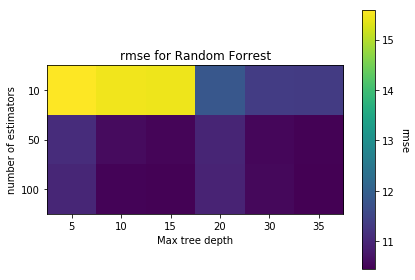

In [13]:
# heatmap of the score for different hyperparameters
# X axis: depth
# y axis: n_estimator
parameters = {'n_estimators': [10,50, 100], 'max_depth':[5, 10, 15, 20, 30, 35]}
rmseLst=[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']]
SCORE= np.array(rmseLst)    # ndarray of all the scores
SCORE.shape=(len(parameters['n_estimators']),len(parameters['max_depth']))
fig, ax = plt.subplots()
im = ax.imshow(SCORE)
ax.set_xticks(np.arange(len(parameters['max_depth'])))
ax.set_yticks(np.arange(len(parameters['n_estimators'])))
ax.set_xticklabels(parameters['max_depth'])
ax.set_yticklabels(parameters['n_estimators'])
ax.set_title("rmse for Random Forrest")
ax.set_xlabel('Max tree depth')
ax.set_ylabel('number of estimators')
# Create colorbar
cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel(rotation=-90, va="bottom", ylabel= 'rmse')

fig.tight_layout()
plt.savefig('RandomForrest-Heatmap.png')
plt.show()


In [11]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)

best estimator = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [54]:
#Now, fit the model 
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n > 1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    model = RandomForestRegressor(n_estimators=100, max_depth=35)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('rmse for Random Forrest: %.2f'%oos_rmse)
#pickle the model
fileName='RandomForrest_model'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()


rmse for Random Forrest: 9.85


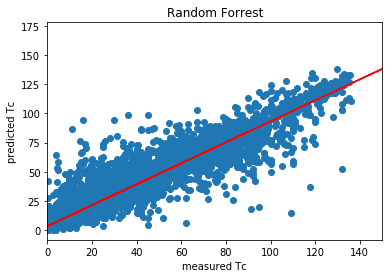

In [55]:
pltxy(y_test,y_pred)
plt.title('Random Forrest')
plt.savefig('RandomForrest.png')
plt.show()

# XgBoost

In [20]:
# hyperparameter tuning. We did not use Gridsearch function. We used our own function for cross validation
startTime=time.time()
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
num_cv=2
Depth=[4, 7,10,15,20,30] #maximum tree depth
Eta=[.1,.2,.3,.4, .5,.7]
oos_rmse=[] # this is the list of rsme for different tree depths
tree_depth=[]# list of tree depths
EtaLst=[]# list of etas
for eta in Eta:
    for depth in Depth:
        for i in range(num_cv):
            mseList=[]# this is a list of rmse for n number of tests
            X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_train.iloc[:,0:81], y_train, test_size=0.33)
            dtrain = xgb.DMatrix(X_xgb_train, label=y_xgb_train)
            dtest = xgb.DMatrix(X_xgb_test, label=y_xgb_test)
            param = {'max_depth':depth, 'eta':eta, 'silent':1}
            model = xgb.train(param, dtrain)
            y_pred = model.predict(dtest)
            mseList.append(mse(y_xgb_test,y_pred))
            print('n = %.2f, eta=%.2f, depth= %.2f'% (i, eta,depth) )# to see progress
        oos_rmse.append(rmse(mseList))
        tree_depth.append(depth)
        EtaLst.append(eta)
fileName='xgb_GridSearchCV'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
xgb_time=time.time()-startTime

n = 0.00, eta=0.10, depth= 4.00
n = 1.00, eta=0.10, depth= 4.00
n = 0.00, eta=0.10, depth= 7.00
n = 1.00, eta=0.10, depth= 7.00
n = 0.00, eta=0.10, depth= 10.00
n = 1.00, eta=0.10, depth= 10.00
n = 0.00, eta=0.10, depth= 15.00
n = 1.00, eta=0.10, depth= 15.00
n = 0.00, eta=0.10, depth= 20.00
n = 1.00, eta=0.10, depth= 20.00
n = 0.00, eta=0.10, depth= 30.00
n = 1.00, eta=0.10, depth= 30.00
n = 0.00, eta=0.20, depth= 4.00
n = 1.00, eta=0.20, depth= 4.00
n = 0.00, eta=0.20, depth= 7.00
n = 1.00, eta=0.20, depth= 7.00
n = 0.00, eta=0.20, depth= 10.00
n = 1.00, eta=0.20, depth= 10.00
n = 0.00, eta=0.20, depth= 15.00
n = 1.00, eta=0.20, depth= 15.00
n = 0.00, eta=0.20, depth= 20.00
n = 1.00, eta=0.20, depth= 20.00
n = 0.00, eta=0.20, depth= 30.00
n = 1.00, eta=0.20, depth= 30.00
n = 0.00, eta=0.30, depth= 4.00
n = 1.00, eta=0.30, depth= 4.00
n = 0.00, eta=0.30, depth= 7.00
n = 1.00, eta=0.30, depth= 7.00
n = 0.00, eta=0.30, depth= 10.00
n = 1.00, eta=0.30, depth= 10.00
n = 0.00, eta=0.30, de

In [57]:
#Instead of running the above code, you could unpickle
fileName='xgb_GridSearchCV'
infile=open(fileName,'rb')
model=pickle.load(infile)
infile.close()


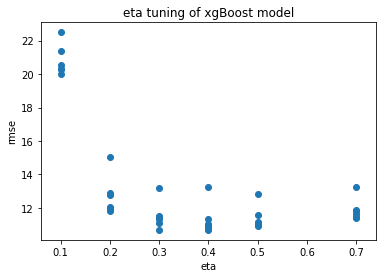

In [21]:
plt.scatter(EtaLst,oos_rmse)
plt.title('eta tuning of xgBoost model')
plt.xlabel('eta')
plt.ylabel('rmse')
plt.savefig('xgBoost_eta_tuning.png')
plt.show()


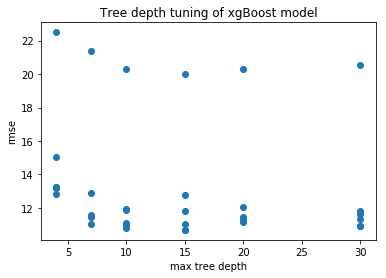

In [22]:
plt.scatter(tree_depth,oos_rmse)
plt.title('Tree depth tuning of xgBoost model')
plt.xlabel('max tree depth')
plt.ylabel('rmse')
plt.savefig('xgBoost_depth_tuning.png')
plt.show()


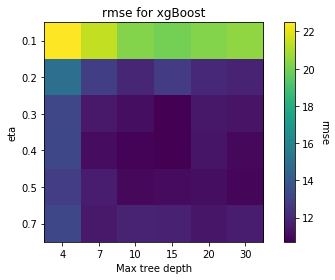

In [23]:
# heatmap of the score for different hyperparameters
# X axis: depth
# y axis: eta
SCORE= np.array(oos_rmse)    # ndarray of all the scores
SCORE.shape=(len(Eta),len(Depth))
fig, ax = plt.subplots()
im = ax.imshow(SCORE)
ax.set_xticks(np.arange(len(Depth)))
ax.set_yticks(np.arange(len(Eta)))
ax.set_xticklabels(Depth)
ax.set_yticklabels(Eta)
ax.set_title("rmse for xgBoost")
ax.set_xlabel('Max tree depth')
ax.set_ylabel('eta')
# Create colorbar
cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel(rotation=-90, va="bottom", ylabel= 'rmse')
fig.tight_layout()
plt.savefig('xgBoost-Heatmap.png')
plt.show()


Based on this analysis, we pick eta of 0.4 and depth of 10

In [58]:
# train and run the model with above hyperparameters
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n >1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    param = {'max_depth':10, 'eta':.4, 'silent':1}
    model = xgb.train(param, dtrain)
    y_pred = model.predict(dtest)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('rmse for xgBoost: %.2f'%oos_rmse)
fileName='xgb_model'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

rmse for xgBoost: 10.28


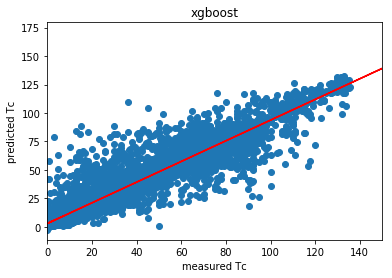

In [60]:
#Instead of running the above code, you could unpickle
#fileName='xgb_model'
#infile=open(fileName,'rb')
#model=pickle.load(infile)
#infile.close()

pltxy(y_test,y_pred)
plt.title('xgboost')
plt.savefig('xgboost.png')
plt.show()

# Neural network

In [32]:
# first we normalizet the features
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
norm_X_train = (X_train - mean) / std
norm_X_test = (X_test - mean) / std


In [40]:
# tune the hyperparameters
startTime=time.time()
parameters = {'solver':['adam', 'lbfgs'], 'hidden_layer_sizes':[(100,100),(81,81), (50,50),(25,25),(12,12)]}
model= GridSearchCV(MLPRegressor(), param_grid=parameters, scoring=scorer, cv=4, verbose=5)
model.fit(norm_X_train, y_train)
# pickle the model
fileName='NN_GridSearchCV'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()
rmseLst=[math.sqrt(abs(i)) for i in model.cv_results_['mean_test_score']]
NN_time=time.time()-startTime

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] hidden_layer_sizes=(100, 100), solver=adam ......................
[CV]  hidden_layer_sizes=(100, 100), solver=adam, score=-175.34633625522784, total=   4.0s
[CV] hidden_layer_sizes=(100, 100), solver=adam ......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 100), solver=adam, score=-178.67366808016666, total=   4.4s
[CV] hidden_layer_sizes=(100, 100), solver=adam ......................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 100), solver=adam, score=-195.81137830184008, total=   3.6s
[CV] hidden_layer_sizes=(100, 100), solver=adam ......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 100), solver=adam, score=-167.58937870446212, total=   4.5s
[CV] hidden_layer_sizes=(100, 100), solver=lbfgs .....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.6s remaining:    0.0s


[CV]  hidden_layer_sizes=(100, 100), solver=lbfgs, score=-139.80853463865282, total=  14.0s
[CV] hidden_layer_sizes=(100, 100), solver=lbfgs .....................
[CV]  hidden_layer_sizes=(100, 100), solver=lbfgs, score=-147.66299770242523, total=  14.8s
[CV] hidden_layer_sizes=(100, 100), solver=lbfgs .....................
[CV]  hidden_layer_sizes=(100, 100), solver=lbfgs, score=-160.0903830777969, total=  15.7s
[CV] hidden_layer_sizes=(100, 100), solver=lbfgs .....................
[CV]  hidden_layer_sizes=(100, 100), solver=lbfgs, score=-138.3120208992414, total=  16.4s
[CV] hidden_layer_sizes=(81, 81), solver=adam ........................
[CV]  hidden_layer_sizes=(81, 81), solver=adam, score=-154.789123748416, total=   7.1s
[CV] hidden_layer_sizes=(81, 81), solver=adam ........................
[CV]  hidden_layer_sizes=(81, 81), solver=adam, score=-171.72159736477815, total=   4.9s
[CV] hidden_layer_sizes=(81, 81), solver=adam ........................
[CV]  hidden_layer_sizes=(81, 81

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.5min finished


In [41]:
# Now get the best hyperparameters from the plot and the functino below
print('best estimator = %s' %model.best_estimator_)
# heatmap of the score for different hyperparameters

best estimator = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


Best paramters are therefore solver=lbfgs and hidden_layer_sizes=(100, 100)

In [46]:
#Now, fit the model 
for i in range(n):
    mseList=[]# this is a list of rmse for n number of tests
    if n > 1:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:81], data.critical_temp, test_size=0.33)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    norm_X_train = (X_train - mean) / std
    norm_X_test = (X_test - mean) / std
    model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(100, 100))
    model.fit(norm_X_train,y_train)
    y_pred = model.predict(norm_X_test)
    mseList.append(mse(y_test,y_pred))
oos_rmse=rmse(mseList)
print('rmse for NN: %.2f'%oos_rmse)
#pickle the model
fileName='NN_model'
outfile=open(fileName,'wb')
pickle.dump(model,outfile)
outfile.close()

rmse for NN: 11.35


# Conclusion
Boosting methods have the best performance: Random Forrest, Gradient Boosting and xgBoost
Of the three, we pick Gradient boost, which has the lowest rmse of 9.68

This model is pickled (saved as GB_model) and then unpickled in the deployment document.